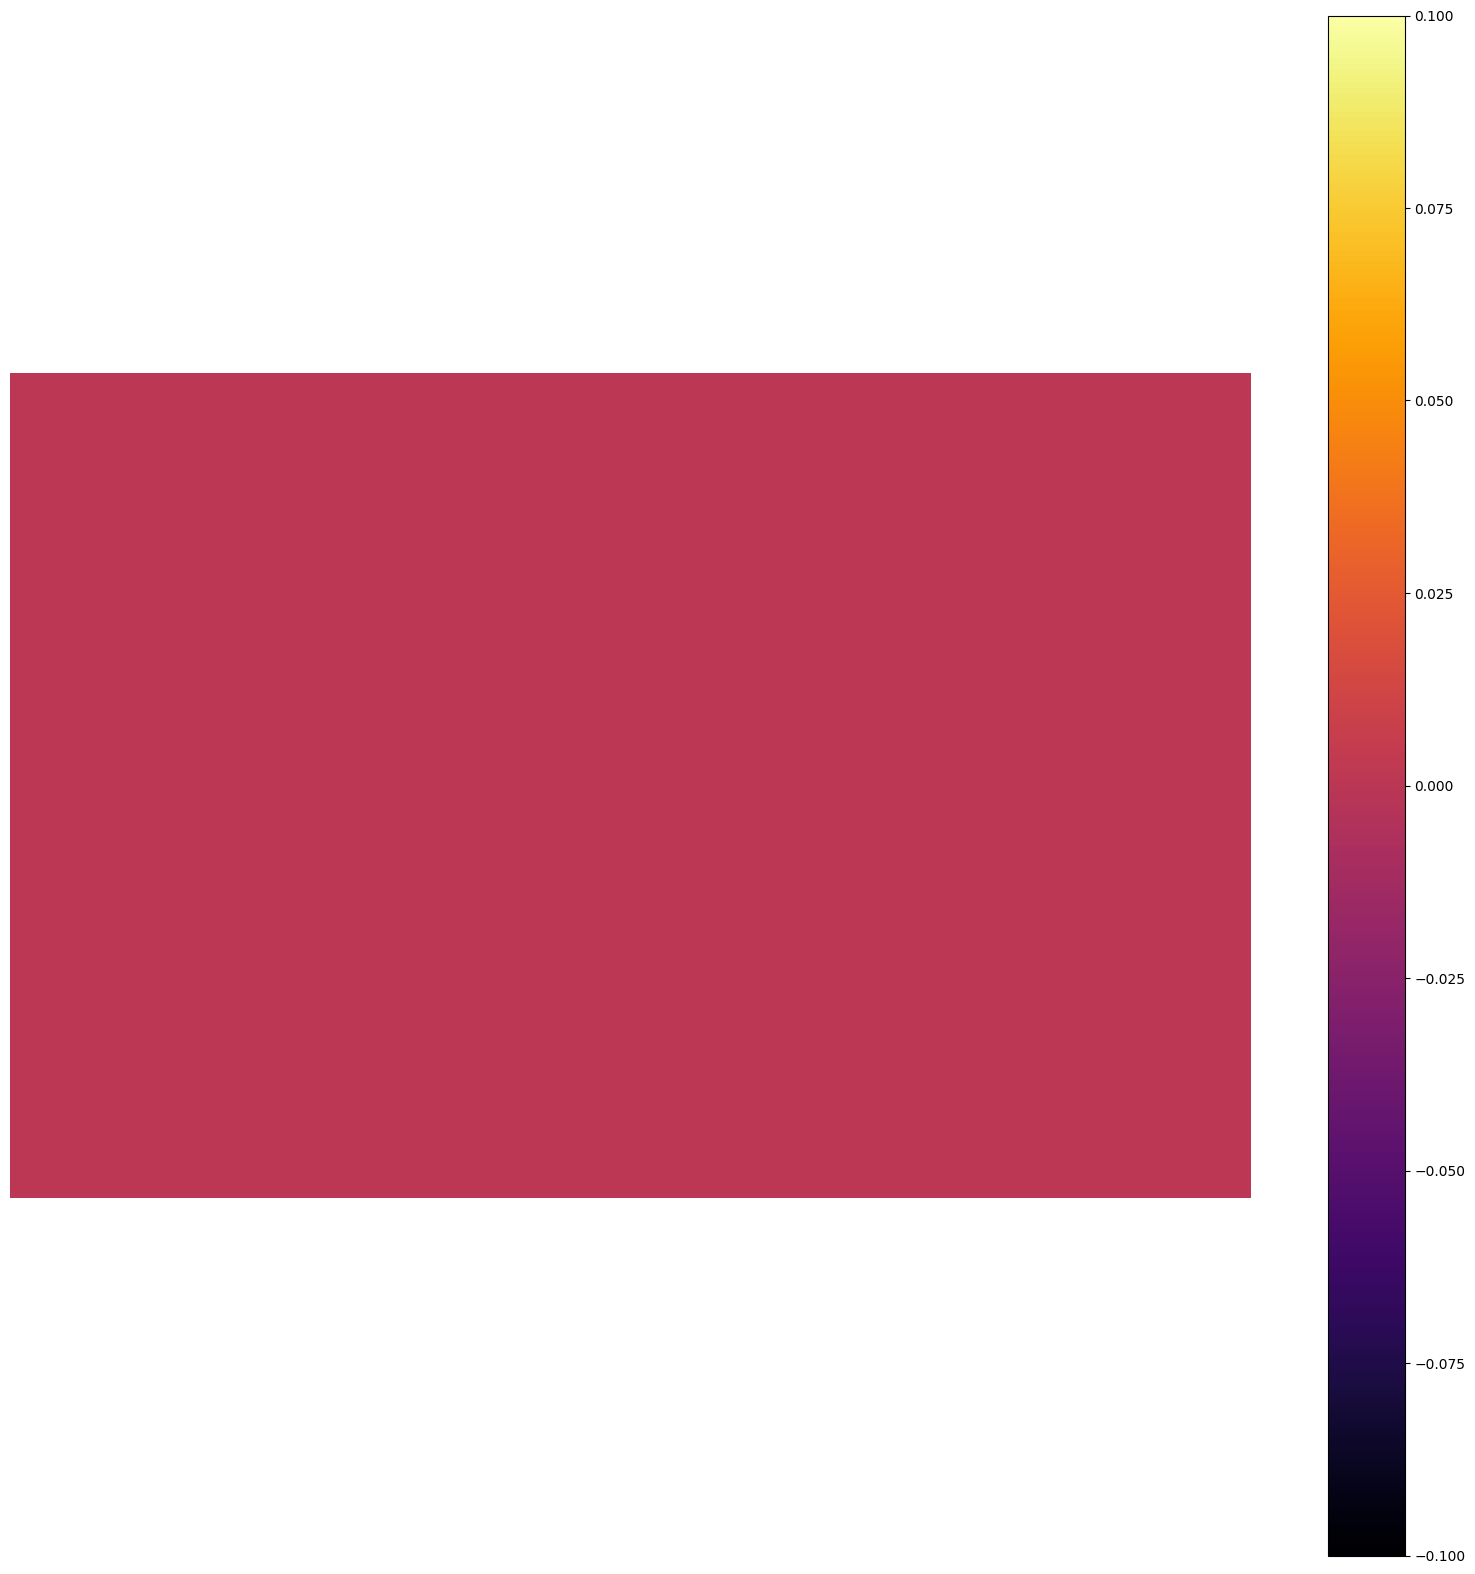

In [2]:
#os.chdir('keras-deeplab-v3-plus-master') # Đi tới thư mục của mã nguồn deeplabv3+

from matplotlib import pyplot as pylab
import cv2  # Dùng để thay đổi kích thước ảnh
import numpy as np
from model import Deeplabv3  # Tải mô hình DeepLabv3
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

# Khởi tạo mô hình Deeplabv3+
deeplab_model = Deeplabv3()

# Đặt đường dẫn thư mục đầu vào và đầu ra
pathIn = 'input'  # Đường dẫn thư mục chứa ảnh đầu vào
pathOut = 'output'  # Đường dẫn thư mục lưu ảnh phân đoạn

# Đọc ảnh đầu vào
img = pylab.imread(pathIn + "/image1.jpg")

# Lấy kích thước ảnh
w, h, _ = img.shape

# Tính toán tỷ lệ cần thiết để resize ảnh sao cho chiều rộng hoặc chiều cao không vượt quá 512px
ratio = 512. / np.max([w, h])

# Thực hiện thay đổi kích thước ảnh theo tỷ lệ tính được
resized = cv2.resize(img, (int(ratio * h), int(ratio * w)))

# Chuẩn hóa giá trị ảnh từ [0, 255] thành [-1, 1]
resized = resized / 127.5 - 1.

# Thêm padding cho ảnh để chiều cao hoặc chiều rộng bằng 512
pad_x = int(512 - resized.shape[0])
resized2 = np.pad(resized, ((0, pad_x), (0, 0), (0, 0)), mode='constant')

# Chuyển đổi resized2 thành tensor TensorFlow
# input_tensor = tf.convert_to_tensor(resized2, dtype=tf.float32)
# res = deeplab_model.predict(tf.expand_dims(input_tensor, 0))


# Dự đoán phân đoạn cho ảnh
# res = deeplab_model.predict(tf.expand_dims(resized2, 0))
res = deeplab_model.call(tf.expand_dims(resized2, 0))


# Lấy nhãn phân đoạn (tức là phân lớp của từng điểm ảnh)
# labels = np.argmax(res.squeeze(), -1)
labels = np.argmax(res.numpy().squeeze(), -1)


# Hiển thị kết quả phân đoạn
pylab.figure(figsize=(20, 20))
pylab.imshow(labels[:-pad_x], cmap='inferno')  # Hiển thị ảnh phân đoạn
pylab.axis('off')  # Tắt trục
pylab.colorbar()  # Hiển thị thanh màu
pylab.show()  # Hiển thị ảnh

# Lưu ảnh phân đoạn ra thư mục đầu ra
pylab.savefig(pathOut + "\\segmented.jpg", bbox_inches='tight', pad_inches=0)
pylab.close()

#os.chdir('..')  # Trở lại thư mục ban đầu nếu cần thiết